# **2D Instance Segmentation pipeline**
___  

In this notebook, we demonstrate the use of the [BiaPy](https://biapyx.github.io/) pipeline for **2D instance segmentation** of microscopy data.

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/mitoem_crop.png' width='300px'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/mitoem_crop_mask.png' width='300px'/>
<figcaption><b>Figure 1</b>: Example of a 2D instance segmentation problem. From left to right: 2D electron microscopy image and its corresponding mitochondria instance labels.</figcaption>
</center>
</figure>

Without any coding, we'll guide you step-by-step through the process to:
1. **Upload a set of training and test images** along with their corresponding instance label images.
2. **Train a Deep Neural Network (DNN)** model using the training set.
3. **Apply the model** to the test images.
4. **Download the segmentation results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired by the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus), [Lenka Backová](mailto:lenka.backova@ehu.eus), [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org) and [Ane Paniagua](mailto:anepaniagua@gmail.com). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/BiaPyX/BiaPy/issues). Thank you!


## **Expected inputs and outputs**
___
**Inputs**

This notebook expects five folders as input:
* **Training raw images**: with the raw 2D images to train the model.
* **Training label images**: with the instance-label 2D images to train the model. Their number and sizes must match those of the training raw images.
* **Test raw images**: with the raw 2D images to test the model.
* **Test label images** (optional): with the instance-label 2D images to test the model. Their number and sizes must match those of the validation raw images.
* **Output folder**: a path to store the segmentation results.

**Outputs**

Upon successful execution, a new folder will be generated containing one result **TIFF image** for every test image. These result images will showcase the instances of the objects of interest as determined by our pipeline.

<font color='red'><b>Note:</b></font> For testing, this notebook can be executed using the **example datasets found under 'Manage file(s) source > Option 3'**.

**Data structure**

To ensure the proper operation of the library the data directory tree should be something like this:

```
dataset/
├── train
│   ├── raw
│   │   ├── training-0001.tif
│   │   ├── training-0002.tif
│   │   ├── . . .
│   │   └── training-9999.tif
│   └── label
│       ├── training_groundtruth-0001.tif
│       ├── training_groundtruth-0002.tif
│       ├── . . .
│       └── training_groundtruth-9999.tif
└── test
    ├── raw
    │   ├── testing-0001.tif
    │   ├── testing-0002.tif
    │   ├── . . .
    │   └── testing-9999.tif
    └── label
        ├── testing_groundtruth-0001.tif
        ├── testing_groundtruth-0002.tif
        ├── . . .
        └── testing_groundtruth-9999.tif
```

**⚠️ Warning:** Ensure that images and their corresponding masks are sorted in the same way. A common approach is to fill with zeros the image number added to the filenames (as in the example).

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).

## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change the Runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Accelerator:** GPU (Graphics Processing Unit)

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.


## **Install BiaPy**
---
This might take some minutes depending on the current installed libraries in Colab.


In [1]:
#@markdown ##Play to install BiaPy and its dependences
# Install latest release of BiaPy
!pip install biapy==3.6.7

# Then install Pytorch + CUDA 11.8
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118

# Finally install some packages that rely on the Pytorch installation
!pip install timm==1.0.14 pytorch-msssim torchmetrics[image]==1.4.*


import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output
from biapy import BiaPy

changed_source = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.9/597.9 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.1 MB/s eta 0:00:00
   ━━━━

## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.


### **Option 1: Upload Files from Your Local Machine**
---

When you select this option, you'll be prompted to upload your files to Colab. Once uploaded, they will be stored in the `/content/input/` directory.


In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train/raw
%cd /content/input/train/raw
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (train label images)

from google.colab import files
!mkdir -p /content/input/train/label
%cd /content/input/train/label
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test raw images)

from google.colab import files
!mkdir -p /content/input/test/raw
%cd /content/input/test/raw
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test label images)

from google.colab import files
!mkdir -p /content/input/test/label
%cd /content/input/test/label
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---

If you wish to use this notebook with data from your Google Drive, you'll first need to mount the drive to this notebook.

Execute the cell below to initiate the Google Drive mounting process. A link will be displayed click on it. In the new browser window that opens, choose your drive and click 'Allow'. Copy the code that appears, return to this notebook, paste the code into the cell, and press 'Enter'. This action grants Colab access to your Google Drive data.

After this process, you can access your data via the **Files** tab, located on the top left of this notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: Download an Example Dataset**
---
Don't have data readily available but still want to test the notebook? No problem! Simply execute the following cell to download a sample dataset.


Specifically, we'll use the [ZeroCostDL4Mic - Stardist example training and test dataset](https://zenodo.org/record/3715492#.Y4m7FjPMJH6) which is publicly available online.

In [2]:
#@markdown ##Play to download an example dataset

import os

!pip install gdown==5.1.0 --quiet
import gdown

os.chdir('/content/')

gdown.download("https://drive.google.com/uc?id=1b7_WDDGEEaEoIpO_1EefVr0w0VQaetmg", "Stardist_v2.zip", quiet=True)

!unzip -q Stardist_v2.zip
!rm Stardist_v2.zip

print( 'Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `train_data_path` to `/content/input/train/raw`
  - Set `train_data_gt_path` to `/content/input/train/label`
  - Set `test_data_path` to `/content/input/test/raw`
  - Set `test_data_gt_path` to `/content/input/test/label`
  - Set `output_path` to `/content/out`
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
- **Option 3 (Use Our Sample Data)**:
  - Set `train_data_path` to `/content/data/train/raw`
  - Set `train_data_gt_path` to `/content/data/train/label`
  - Set `test_data_path` to `/content/data/test/raw`
  - Set `test_data_gt_path` to `/content/data/test/label`
  - Set `output_path` to `/content/out`

  **Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [3]:
#@markdown #####Path to train raw images
train_data_path = '/content/data/train/raw' #@param {type:"string"}
#@markdown #####Path to train label images
train_data_gt_path = '/content/data/train/label' #@param {type:"string"}
#@markdown #####Path to test raw images
test_data_path = '/content/data/test/raw' #@param {type:"string"}
#@markdown #####Path to test label images (optional)
test_data_gt_path = '/content/data/test/label' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}


import os
from pathlib import Path

def count_image_files(directory):
    if not directory or not os.path.exists(directory):
        return 0
    image_extensions = {'.jpg', '.jpeg', '.png', '.tif', '.npy', '.tiff', '.h5', '.hd5', '.zarr'}
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if Path(file).suffix.lower() in image_extensions:
                count += 1
    return count

num_train_images = count_image_files(train_data_path)
num_train_labels = count_image_files(train_data_gt_path)

num_test_images = count_image_files(test_data_path)
num_test_labels = count_image_files(test_data_gt_path)

print(f"Number of training raw images: {num_train_images}")
print(f"Number of training label images: {num_train_labels}")
print(f"Number of test raw images: {num_test_images}")
if test_data_gt_path != "":
    print(f"Number of test label images: {num_test_labels}")

if num_train_images != num_train_labels:
    print("Error: The number of training raw images does not match the number of training label images.")
if test_data_gt_path != "" and num_test_images != num_test_labels:
    print("Error: The number of test raw images does not match the number of test label images.")

Number of training raw images: 45
Number of training label images: 45
Number of test raw images: 2
Number of test label images: 2


## **Dataset Visualization**
---

In [4]:
# @markdown ## Play to visualize some data samples
# @markdown Select the *Set* (training or test) to visualize samples from, and use the *Image index* scroll to navigate among images.

# @markdown **Notes**: it might take a few seconds to refresh the images. Images are displayed with color maps to facilitate visualization.
%matplotlib inline
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import os
from ipywidgets import interact, IntSlider, Layout, Dropdown, HBox, Output

# Initialize paths and image IDs
input_path = train_data_path
gt_path = train_data_gt_path

ids_input = sorted(next(os.walk(input_path))[2])
ids_gt = sorted(next(os.walk(gt_path))[2])

# Create random color map
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_rainbow(vals))
cmap.colors[0] = [0., 0., 0., 1.] # set background to black

# Dropdown widget to choose training or test set
dropdown = Dropdown(
    options=['training-set', 'test-set'],
    value='training-set',
    description='Set:',
    disabled=False,
)

# Slider widget to choose instance
slider= IntSlider(
    value=0,
    min=1,
    max=len(ids_input),
    step=1,
    description='Image index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='500px', margin = '0 0 0 10px')
)

slider.style.description_width = 'initial'
slider.style.handle_color='blue'

# Initialize Output instance to handle code output cell
output = Output()

# Function to display images depending on slider value
def display_images(change):
    with output:
        output.clear_output(wait=True)
        index = change['new']

        global input_path, ids_input, input_img
        input_img_path = os.path.join(input_path, ids_input[index-1])
        input_img = imread(input_img_path)

        # # Print sample path to ensure the image displayed is correct
        # print(input_img_path)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title(f"Raw image: {index}")
        plt.imshow(input_img, cmap='magma', vmin=np.percentile(input_img,0.1),vmax=np.percentile(input_img,99.9))
        # plt.axis('off')

        global gt_path, ids_gt, gt_img
        if ids_gt != []: # If StopIteration exception was not thrown
            gt_img_path = os.path.join(gt_path, ids_gt[index-1])
            gt_img = imread(gt_img_path).astype(np.uint16)
            plt.subplot(1, 2, 2)
            plt.title("Label image")
            plt.imshow(gt_img,  cmap=cmap, interpolation='nearest')
            # plt.axis('off')

            # # Print label path to ensure the image displayed is correct
            # print(gt_img_path)

        else:
            print("No labels for this set.")

        # print(f"Instance path: {input_img_path}")
        # print(f"Label path: {gt_img_path}")

        plt.show()

# Function to update paths and image IDs (input_path, ids_input, gt_path, ids_gt)
def update_paths(change):
    global input_path, gt_path
    if change.new == 'test-set':
        input_path = test_data_path
        gt_path = test_data_gt_path
    else:
        input_path = train_data_path
        gt_path = train_data_gt_path

    global ids_input, ids_gt
    ids_input = sorted(next(os.walk(input_path))[2])
    try:
        ids_gt = sorted(next(os.walk(gt_path))[2])
    except StopIteration:
        ids_gt = []

    # Reset slider value when dropdown changes
    slider.value = 1
    slider.max = len(ids_input)
    display_images({'new': 1})

# Create an HBox to hold the dropdown and slider
controls = HBox([dropdown, slider])
display(controls, output)

# Link widgets to functions
slider.observe(display_images, names='value')
dropdown.observe(update_paths, names='value')

# Initial display
display_images({'new': slider.value})

Output()

## **Configure and Train the DNN Model**
---

[BiaPy](https://biapy.readthedocs.io/en/latest/) adopts a bottom-up approach to both 2D and 3D instance segmentation. It learns the binary masks, contours (or center points), and (optionally) the distance map of the objects of interest. These learned elements are later post-processed using marker-controlled watershed as detailed in [Wei et al. 2020](https://link.springer.com/chapter/10.1007/978-3-030-59722-1_7).

<figure>
<center>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/refs/heads/master/source/img/instance_bcd_scheme.svg' width='480px'/>
<figcaption><b>Figure 2</b>: Multi-channel representation for instance segmentation. Label instances are deduced by predicting their foreground mask, contours, and distance maps as described in <a href="https://link.springer.com/chapter/10.1007/978-3-030-59722-1_7">Wei et al. 2020</a>.</figcaption></center>
</figure>

To configure these representations and other pipeline hyperparameters, you can either edit the YAML configuration file directly or, more simply, execute the following cells.


In [21]:
# @markdown ###OPTIONAL: Check BioImage Model Zoo (BMZ) models compatible with BiaPy
# @markdown Use this option to generate a full list of the available BiaPy-compatible models in the BMZ.

# @markdown **Important:** To select one of the listed models (if any), you will have to run the next cell and select "BioImage Model Zoo" as the source of the model. Then, paste the corresponding model's nickname into the created field.
# @markdown <div><img src="https://bioimage.io/static/img/bioimage-io-logo.svg" width="600"/></div>


import json
import pooch
from IPython.display import HTML, display
from tqdm.notebook import tqdm

import requests
from biapy.models import check_bmz_model_compatibility, find_bmz_models

# Change pooch verbosity
logger = pooch.get_logger()
logger.setLevel("WARNING")

# Check the models that BiaPy can consume
models = find_bmz_models()

# Check axes, preprocessing functions used and postprocessing.
pytorch_models = []
imposed_vars = []

workflow_specs = {
    "workflow_type": "INSTANCE_SEG",
    "ndim": "2D",
    "nclasses": "all",
}
if len(models) > 0:
    print("Analizing models from the Zoo . . .")

for model in tqdm(models, total=len(models)):
    try:
        (
            preproc_info,
            error,
            error_message,
            model_imposed_vars
        ) = check_bmz_model_compatibility(model, workflow_specs=workflow_specs)
    except:
        error = True

    if not error:
        imposed_vars.append(model_imposed_vars)
        pytorch_models.append(model)

# Print the possible models
html = "<table style='width:100%''>"
c = 0
for i, model in enumerate(pytorch_models):

    nickname = "Nick not found"
    if 'nickname' in model:
        nickname = model['nickname']
    elif 'alias' in model:
        nickname = model['alias']

    nickname_icon = "Emoji not found"
    if 'id_emoji' in model["raw"]["manifest"]:
        nickname_icon = model["raw"]["manifest"]['id_emoji']

    cover_url = "https://hypha.aicell.io/bioimage-io/artifacts/{}/files/{}".format(nickname, model["raw"]["manifest"]['covers'][0])
    restrictions = ""
    for key, val in imposed_vars[i].items():
        if key == 'MODEL.N_CLASSES':
            restrictions += "<p>number_of_classes: {}</p>".format(val)
        elif key == "PROBLEM.INSTANCE_SEG.DATA_CHANNELS":
            problem_channels = 'Binary mask + Contours'
            if val == "BC":
                problem_channels = "Binary mask + Contours"
            elif val == 'BP':
                problem_channels = "Binary mask + Central points"
            elif val == 'BD':
                problem_channels = "Binary mask + Distance map"
            elif val == 'BCM':
                problem_channels = "Binary mask + Contours + Foreground mask"
            elif val == 'BCD':
                problem_channels = "Binary mask + Contours + Distance map"
            elif val == 'BCDv2':
                problem_channels = "Binary mask + Contours + Distance map with background"
            elif val == 'Dv2':
                problem_channels = "Distance map with background"
            restrictions += "<p>Problem representation: {}</p>".format(problem_channels)
    if c == 0:
        html += "<tr>"
    html += "<td style='width:33%'>"
    html += "<p style='color:#2196f3'>%s</p><p>Nickname: %s (%s)</p>%s<img src='%s' height='130'></td>"%(
        model["raw"]["manifest"]['name'],
        nickname,
        nickname_icon,
        restrictions,
        cover_url,
    )
    c +=1
    if c == 3:
        html += "</tr>"
        c=0

html += "</table>"
if len( pytorch_models ) == 0:
    display(HTML('<h1>No BMZ models compatible with BiaPy were found for this task.</h1><br>'))
else:
    display(HTML('<h1>List of models that can be used in BiaPy:</h1><br>'))
    display(HTML(html))


[11:47:59.111669] Analizing models from the Zoo . . .


  0%|          | 0/123 [00:00<?, ?it/s]

In [6]:
#@markdown ###Play to select the source to build the model (BiaPy, Torchvision or BioImage Model Zoo) { run: "auto", vertical-output: true, display-mode: "form" }

#@markdown **BiaPy**: to use the models implemented in BiaPy.

#@markdown **Torchvision**: to use models from [Torchvision](https://pytorch.org/vision/stable/index.html).

#@markdown **Bioimage Model Zoo (BMZ)**: to use models from the [BMZ repository](https://bioimage.io/#/). You can run the above cell to generate an updated list of the models that can be used with BiaPy. Copy the nickname from the model and paste it below.
import ipywidgets as widgets
from ipywidgets import Output

changed_source = True
exists_tv = False
exists_bmz = False
# create widgets
source = widgets.ToggleButtons(
    options=['BiaPy', 'Torchvision', 'BioImage Model Zoo'],
    description='Source:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Models created during this workflow', 'Torchvision model', 'BioImage Model Zoo model'],
#     icons=['check'] * 3
)


t_vision = widgets.Dropdown(
    options=['deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'fcn_resnet101', 'fcn_resnet50', 'lraspp_mobilenet_v3_large'],
    value='fcn_resnet50',
    description='Supported:',
    disabled=False,
)

bmz = widgets.Text(
    # value='10.5281/zenodo.5764892',
    placeholder='Nickname of BMZ model',
    description='ID:',
    disabled=False
)

# display the first widget
display(source)

# intialize the output - second widget
out = Output()

def changed(change):
    '''
    Monitor change in the first widget
    '''
    global out
    global exists_bmz
    global exists_tv
    if source.value == 'BiaPy':
        bmz.layout.display = 'none'
        t_vision.layout.display = 'none'
        out.clear_output() #clear output
        out = Output() # redefine output
    else:
        if source.value == 'Torchvision':
          bmz.layout.display = 'none'
          t_vision.layout.display = 'none'
          t_vision.layout.display = 'flex'
          if not exists_tv:
            out.append_display_data(t_vision)
            display(out)
          exists_tv = True
        else:
          t_vision.layout.display = 'none'
          bmz.layout.display = 'none'
          bmz.layout.display = 'flex'
          if not exists_bmz:
            out.append_display_data(bmz)
            display(out)
          exists_bmz = True

# monitor the source widget for changes
source.observe(changed, 'value')

ToggleButtons(description='Source:', options=('BiaPy', 'Torchvision', 'BioImage Model Zoo'), tooltips=('Models…

### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**
* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`test_ground_truth`:** Select to use test data ground truth to measure the performance of the model's result. If selected, **test_data_gt_path** variable path set above will be used. **Default value: True**

#### **Basic training parameters**
* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, reasonable results can already be observed after 100 epochs. **Default value: 100**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:** Select the architecture of the DNN used as backbone of the pipeline. Options: U-Net, Residual U-Net, Attention U-Net, SEUNet, MultiResUNet, ResUNet++ (see [Franco-Barranco et al., 2021](https://link.springer.com/article/10.1007/s12021-021-09556-1)), UNETR-Mini, UNETR-Small, UNETR-Base and U-NeXt V1.  **Default value: U-Net**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 8**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 256**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization.**Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM or ADAMW as optimizer, this value should be around 10e-4. **Default value: 0.0001**

* **`learning_rate_scheduler`:** Select to adjust the learning rate between epochs. Options: "None", "Reduce on plateau", "One cycle", "Warm-up cosine decay". **Default value: None**

* **`problem_representation`:** Select the type of representation that the model must learn to identify the instances. Options: "Binary mask + Contours", "Binary mask + Central points", "Binary mask + Contours + Distance map", "Binary mask + Contours + Foreground mask" (see <a href="https://link.springer.com/chapter/10.1007/978-3-030-59722-1_7">Wei et al. 2020</a>). **Default value: "Binary mask + Contours"**

* **`aggressive_data_augmentation`:** Select to apply more aggressive data augmentation (CutBlur, CutNoise, GridMask, etc.) during training. Otherwise, simple flips and rotations will be applied. **Default value: False**

* **`test_time_augmentation`:** Select to apply augmentation (flips and rotations) at test time. It usually provides more robust results but uses more time to produce each result. **Default value: False**

In [7]:
#@markdown ###Name of the model:
model_name = "my_2d_instance_segmentation" #@param {type:"string"}

#@markdown ### Data management:
test_ground_truth = True #@param {type:"boolean"}
percentage_validation =  10 #@param {type:"number"}

#@markdown ### Basic training parameters:
input_channels = 1 #@param {type:"number"}
number_of_epochs =  100#@param {type:"number"}
patience =  20#@param {type:"number"}

#@markdown ### Advanced training parameters:

model_architecture = "U-Net" #@param ["U-Net", "Residual U-Net", "Attention U-Net", 'MultiResUNet', 'ResUNet++', 'SEUNet', "UNETR-Mini","UNETR-Small", "UNETR-Base", "U-NeXt V1"]
batch_size =  8#@param {type:"number"}
patch_size = 256 #@param {type:"number"}
optimizer = "ADAMW" #@param ["ADAM", "SGD","ADAMW"]
initial_learning_rate = 0.0001 #@param {type:"number"}
problem_representation = "Binary mask + Contours" #@param ["Binary mask + Contours", "Binary mask + Central points", "Binary mask + Distance map","Binary mask + Contours + Distance map", "Binary mask + Contours + Foreground mask", "Binary mask + Contours + Distance map with background", "Distance map with background"]
learning_rate_scheduler = "None" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]
aggressive_data_augmentation = False #@param {type:"boolean"}
test_time_augmentation = False #@param {type:"boolean"}

checkpoint_path = ''

In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

if len(uploaded) > 0:

    checkpoint_path = '/content/' + list(uploaded.keys())[0]

    # open previously configured file, if exists
    job_name = model_name
    yaml_file = "/content/"+str(job_name)+".yaml"

    # edit previous configuration file if it exists to load the checkpoint model
    if os.path.exists( yaml_file ):
        import yaml
        with open( yaml_file, 'r') as stream:
            try:
                biapy_config = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
        biapy_config['PATHS'] = {}
        biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
        biapy_config['MODEL'] = {}
        biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

        # save file
        with open( yaml_file, 'w') as outfile:
            yaml.dump(biapy_config, outfile, default_flow_style=False)

    print( "Pre-trained model loaded and ready to re-train.")

### **Train the model**
---

In [8]:
#@markdown ##Play to train the model
import os
import errno
from biapy import BiaPy

os.chdir('/content/')

job_name = model_name

yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_instance_segmentation.yaml'

if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
import shutil
!wget https://raw.githubusercontent.com/BiaPyX/BiaPy/master/templates/instance_segmentation/2d_instance_segmentation.yaml &> /dev/null

#/content/BiaPy/templates/instance_segmentation/2d_instance_segmentation.yaml
# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_path))
if not os.path.exists(train_data_gt_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_gt_path)
ids = sorted(next(os.walk(train_data_gt_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_gt_path))

# Check folders before modifying the .yaml file
if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(test_data_path))
if test_ground_truth:
    if not os.path.exists(test_data_gt_path):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_gt_path)
    ids = sorted(next(os.walk(test_data_gt_path))[2])
    if len(ids) == 0:
        raise ValueError("No images found in dir {}".format(test_data_gt_path))


# open template configuration file
import yaml
with open( '2d_instance_segmentation.yaml', 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA'] = {}
biapy_config['DATA']['TRAIN'] = {}
biapy_config['DATA']['TRAIN'] ['PATH']= {}
biapy_config['DATA']['TEST'] = {}
biapy_config['DATA']['TEST']['PATH'] = {}
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TRAIN']['GT_PATH'] = train_data_gt_path
biapy_config['DATA']['TEST']['PATH'] = test_data_path
biapy_config['DATA']['TEST']['GT_PATH'] = test_data_gt_path

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding)+', '+ str(padding)+')'

# update training parameters
biapy_config['DATA']['VAL'] = {}
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']={}
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
if number_of_epochs < 10:
    biapy_config['LOG'] = {}
    biapy_config['LOG']['CHART_CREATION_FREQ'] = 1
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate
biapy_config['TRAIN']['ENABLE'] = True

# change source to build model - biapy, torchvision or bmz
if changed_source:
    if source.value == "BiaPy":
        biapy_config['MODEL']['SOURCE'] = "biapy"
    elif source.value == 'Torchvision':
        biapy_config['MODEL']['SOURCE'] = "torchvision"
        biapy_config['MODEL']['TORCHVISION_MODEL_NAME'] = t_vision.value
    elif source.value == 'BioImage Model Zoo':
        biapy_config['MODEL']['SOURCE'] = "bmz"
        biapy_config['MODEL']['BMZ'] = {}
        biapy_config['MODEL']['BMZ']['SOURCE_MODEL_ID'] = str(bmz.value).strip()
else:
    biapy_config['MODEL']['SOURCE'] = "biapy"

# Transcribe problem representation
#   BC = "Binary mask + Contours"
#   BCM = "Binary mask + Contours + Foreground mask"
#   BCD = "Binary mask + Contours + Distance map"
#   BCDv2 = "Binary mask + Contours + Distance map with background"
#   Dv2 = "Distance map with background"
#   BDv2 = "Binary mask + Distance map with background"
#   BP = "Binary mask + Central points"
#   BD = "Binary mask + Distance map"
problem_channels = 'BC'
if problem_representation == "Binary mask + Contours":
    problem_channels = 'BC'
elif problem_representation == "Binary mask + Central points":
    problem_channels = 'BP'
elif problem_representation == "Binary mask + Distance map":
    problem_channels = 'BD'
elif problem_representation == "Binary mask + Contours + Foreground mask":
    problem_channels = 'BCM'
elif problem_representation == "Binary mask + Contours + Distance map":
    problem_channels = 'BCD'
elif problem_representation == "Binary mask + Contours + Distance map with background":
    problem_channels = 'BCDv2'
elif problem_representation == "Distance map with background":
    problem_channels = 'Dv2'
else:
    problem_channels = 'BDv2'

biapy_config['PROBLEM']['INSTANCE_SEG']['DATA_CHANNELS'] = problem_channels
biapy_config['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_TYPE'] = "auto"

# Transcribe model architecture
# Available models: "U-Net", "Residual U-Net", "Attention U-Net",
# 'MultiResUNet', 'SEUNet', 'ResUNet++', "UNETR-Mini","UNETR-Small"
# "UNETR-Base"
architecture = 'unet'
if model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "MultiResUNet":
    architecture = 'multiresunet'
elif model_architecture == "ResUNet++":
    architecture = 'resunet++'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
elif model_architecture == "UNETR-Mini":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 64
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 4
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4. # to get 256
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 4
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 1
    biapy_config['TEST']['FULL_IMG'] = False
elif model_architecture == "UNETR-Small":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 128
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 8
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4. # to get 512
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 8
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 2
    biapy_config['TEST']['FULL_IMG'] = False
elif model_architecture == "UNETR-Base":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 256
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 12
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 3. # to get 768
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 12
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 3
    biapy_config['TEST']['FULL_IMG'] = False
else: # U-NeXt V1
    architecture = 'unext_v1'
    biapy_config['MODEL']['FEATURE_MAPS'] = "[16, 32, 64, 128, 256]"
    biapy_config['MODEL']['CONVNEXT_LAYERS'] = "[1, 1, 1, 1, 1]"
    biapy_config['MODEL']['CONVNEXT_STEM_K_SIZE'] = 1

biapy_config['MODEL']['ARCHITECTURE'] = architecture

# Class rebalance
biapy_config['LOSS'] = {}
biapy_config['LOSS']['CLASS_REBALANCE'] = True

# Data augmentation
if aggressive_data_augmentation == True:
    biapy_config['AUGMENTOR']['DROPOUT'] = True
    biapy_config['AUGMENTOR']['GRIDMASK'] = True
    biapy_config['AUGMENTOR']['CUTBLUR'] = True
    biapy_config['AUGMENTOR']['CUTNOISE'] = True
    biapy_config['AUGMENTOR']['MOTION_BLUR'] = True
    #biapy_config['AUGMENTOR']['ELASTIC'] = True
    #biapy_config['AUGMENTOR']['CUTOUT'] = True
    #biapy_config['AUGMENTOR']['BRIGHTNESS'] = True
    #biapy_config['AUGMENTOR']['CONTRAST'] = True

# learning rate scheduler
if learning_rate_scheduler == 'One cycle':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'onecycle'
elif learning_rate_scheduler == 'Warm-up cosine decay':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'warmupcosine'
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.0
    biapy_config['TRAIN']['LR_SCHEDULER']['WARMUP_COSINE_DECAY_EPOCHS'] = 0
elif learning_rate_scheduler == 'Reduce on plateau':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'reduceonplateau'
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_FACTOR'] = 0.5
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_PATIENCE'] = 5
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.00001

# update test parameters
biapy_config['TEST']['AUGMENTATION'] = test_time_augmentation
biapy_config['DATA']['TEST']['LOAD_GT'] = test_ground_truth
biapy_config['TEST']['ENABLE'] = True

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

# Run the code
biapy = BiaPy(f'/content/{job_name}.yaml', result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()

Training configuration finished.
Date     : 2025-11-11 11:13:24
Arguments: Namespace(config='/content/my_2d_instance_segmentation.yaml', result_dir='/content/output', name='my_2d_instance_segmentation', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job      : my_2d_instance_segmentation_1
BiaPy    : 3.6.7
Python   : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch  : 2.4.0+cu118
The following changes were made in order to adapt the input configuration:
Not using distributed mode
[11:13:24.816764] Configuration details:
[11:13:24.816880] AUGMENTOR:
  AFFINE_MODE: reflect
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_FACTOR: (-0.1, 0.1)
  C

  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|       

[11:13:42.381633] You select to create ['F', 'C'] channels from given instance labels and no file is detected in /content/data/test/label_F.erosion-0.dilation-0_C.mode-thick . So let's prepare the data. This process will be done just once!
[11:13:42.382131] Creating Y_test channels . . .


  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


[11:13:42.715110] DATA.TRAIN.GT_PATH changed from /content/data/train/label to /content/data/train/label_F.erosion-0.dilation-0_C.mode-thick
[11:13:42.715188] DATA.TEST.GT_PATH changed from /content/data/test/label to /content/data/test/label_F.erosion-0.dilation-0_C.mode-thick
[11:13:42.715957] ##########################
[11:13:42.716041] #   LOAD TRAINING DATA   #
[11:13:42.716101] ##########################
[11:13:42.716335] ### LOAD ###
[11:13:42.718518] Gathering raw images for training data . . .
[11:13:42.967288] Gathering labels for training data . . .
[11:13:43.595216] Checking training raw and label images' shapes . . .
[11:13:43.596385] Creating validation data from train . . .
[11:13:43.634572] Raw images chosen for training: ['/content/data/train/raw/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image1.tif', '/content/data/train/raw/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image7.tif', '/content/data/train/raw/cell migration R1 - Position 0_XY15626

100%|██████████| 640/640 [00:00<00:00, 5706.96it/s]


[11:13:43.749098] *** Loaded data shape is (640, 256, 256)
[11:13:43.749196] * Loading train GT . . .


100%|██████████| 640/640 [00:00<00:00, 1577.36it/s]


[11:13:44.158395] *** Loaded data shape is (640, 256, 256)
[11:13:44.158486] * Loading validation images . . .


100%|██████████| 80/80 [00:00<00:00, 4244.71it/s]


[11:13:44.180493] *** Loaded data shape is (80, 256, 256)
[11:13:44.180563] * Loading validation GT . . .


100%|██████████| 80/80 [00:00<00:00, 6184.12it/s]


[11:13:44.197327] *** Loaded data shape is (80, 256, 256)
[11:13:44.197393] ### LOAD RESULTS ###
[11:13:44.197439] *** Loaded train data shape is: (640, 256, 256)
[11:13:44.197465] *** Loaded train GT shape is: (640, 256, 256)
[11:13:44.197489] *** Loaded validation data shape is: (80, 256, 256)
[11:13:44.197512] *** Loaded validation GT shape is: (80, 256, 256)
[11:13:44.197531] ### END LOAD ###
[11:13:44.197567] ###############
[11:13:44.197587] # Build model #
[11:13:44.197606] ###############
[11:13:45.710101] ##############################
[11:13:45.710247] #  PREPARE TRAIN GENERATORS  #
[11:13:45.710276] ##############################
[11:13:45.710397] Initializing train data generator . . .
[11:13:45.711185] Checking which channel of the mask needs normalization . . .


100%|██████████| 1/1 [00:00<00:00, 266.69it/s]


[11:13:45.718671] Normalization config used for X: {'type': 'zero_mean_unit_variance', 'measure_by': 'image', 'mask_norm': 'as_mask', 'out_dtype': 'float32', 'do_percentile_clipping': False, 'channels_to_analize': 2, 'channel_info': {0: {'type': 'bin', 'div': False}, 1: {'type': 'bin', 'div': False}}, 'train_normalization': True, 'eps': 1e-06, 'fixed_mean': None, 'fixed_std': None, 'mean': 0.04834413528442383, 'std': 0.21449237717929548, 'last_X_norm': None, 'last_Y_norm': None, 'last_X_norm_extra_info': {'orig_dtype': 'uint16', 'mean': 60.361945152282715, 'std': 135.52028910576433}, 'last_Y_norm_extra_info': {}}
[11:13:45.718766] Normalization config used for Y: as_mask
[11:13:45.718934] Initializing val data generator . . .
[11:13:45.720099] Checking which channel of the mask needs normalization . . .


100%|██████████| 1/1 [00:00<00:00, 196.57it/s]


[11:13:45.730582] Normalization config used for X: {'type': 'zero_mean_unit_variance', 'measure_by': 'image', 'mask_norm': 'as_mask', 'out_dtype': 'float32', 'do_percentile_clipping': False, 'channels_to_analize': 2, 'channel_info': {0: {'type': 'bin', 'div': False}, 1: {'type': 'bin', 'div': False}}, 'train_normalization': True, 'eps': 1e-06, 'fixed_mean': None, 'fixed_std': None, 'mean': 0.05167531967163086, 'std': 0.22137068687716, 'last_X_norm': None, 'last_Y_norm': None, 'last_X_norm_extra_info': {'orig_dtype': 'uint16', 'mean': 63.84596252441406, 'std': 134.4540356438125}, 'last_Y_norm_extra_info': {}}
[11:13:45.730676] Normalization config used for Y: as_mask
[11:13:45.730779] Creating generator samples . . .
[11:13:45.730845] 0) Creating samples of data augmentation . . .


  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|       

[11:13:46.543153] Train/val generators with 5 workers
[11:13:46.543218] Accumulate grad iterations: 1
[11:13:46.543255] Effective batch size: 8
[11:13:46.543291] Sampler_train = None
[11:13:46.547261] #######################
[11:13:46.547327] # Prepare logging tool #
[11:13:46.547362] #######################
[11:13:46.550101] AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.02
)
[11:13:46.550234] #####################
[11:13:46.550273] #  TRAIN THE MODEL  #
[11:13:46.550305] #####################
[11:13:46.550342] Start training in epoch 1 - Total: 100
[11:13:46.550388] ~~~ Epoch 1/100 ~~~




/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[11:13:52.639948] Epoch: [1]  [ 0/80]  eta: 0:08:06  loss: 2.9479 (2.9479)  IoU (F channel): 0.0899 (0.0899)  IoU (C channel): 0.0603 (0.0603)  lr: 0.000100  iter-time: 6.0872
[11:13:54.057454] Epoch: [1]  [10/80]  eta: 0:00:47  loss: 2.4878 (2.4358)  IoU (F channel): 0.1376 (0.1510)  IoU (C channel): 0.0709 (0.0566)  lr: 0.000100  iter-time: 0.6820
[11:13:55.381902] Epoch: [1]  [20/80]  eta: 0:00:25  loss: 2.0870 (2.1827)  IoU (F channel): 0.2291 (0.2484)  IoU (C channel): 0.0681 (0.0635)  lr: 0.000100  iter-time: 0.1370
[11:13:56.519698] Epoch: [1]  [30/80]  eta: 0:00:16  loss: 1.7785 (2.0244)  IoU (F channel): 0.4284 (0.3233)  IoU (C channel): 0.0906 (0.0742)  lr: 0.000100  iter-time: 0.1230
[11:13:57.415305] Epoch: [1]  [40/80]  eta: 0:00:10  loss: 1.5653 (1.8990)  IoU (F channel): 0.4602 (0.3526)  IoU (C channel): 0.0943 (0.0762)  lr: 0.000100  iter-time: 0.1016
[11:13:58.352873] Epoch: [1]  [50/80]  eta: 0:00:06  loss: 1.4857 (1.8082)  IoU (F channel): 0.4614 (0.3789)  IoU (C cha

[11:29:34.002307] ### MERGE-OV-CROP ###
[11:29:34.002396] Merging (36, 256, 256, 2) images into (1, 1024, 1024, 2) with overlapping . . .
[11:29:34.002436] Minimum overlap selected: (0, 0)
[11:29:34.002472] Padding: (32, 32)
[11:29:34.005264] Real overlapping (%): (0.13020833333333334, 0.13020833333333334)
[11:29:34.005347] Real overlapping (pixels): (25.0, 25.0)
[11:29:34.005385] (6, 6) patches per (x,y) axis
[11:29:34.053997] **** New data shape is: (1, 1024, 1024, 2)
[11:29:34.054094] ### END MERGE-OV-CROP ###
[11:29:34.054878] Saving (1, 1024, 1024, 2) data as .tif in folder: /content/output/my_2d_instance_segmentation/results/my_2d_instance_segmentation_1/per_image


[11:29:34.234545] Creating instances with watershed . . .
[11:29:34.324937] Thresholds used: {'seed': [0.4710731506347656, 0.40951007604599], 'growth_mask': [0.2355365753173828]}
[11:29:34.384753] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_instance_segmentation/results/my_2d_instance_segmentation_1/per_image_instances


[11:29:34.402929] Calculating matching stats . . .
[11:29:34.403032] Its respective image seems to be: /content/data/test/label/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image76.tif
[11:29:35.119448] DatasetMatching: {'criterion': 'iou', 'thresh': 0.3, 'fp': 22, 'tp': 204, 'fn': 5, 'precision': 0.9026548672566371, 'recall': 0.9760765550239234, 'accuracy': 0.8831168831168831, 'f1': 0.9379310344827586, 'n_true': 209, 'n_pred': 226, 'mean_true_score': np.float32(0.72453475), 'mean_matched_score': np.float32(0.74229294), 'panoptic_quality': np.float32(0.6962196)}
[11:29:35.124263] DatasetMatching: {'criterion': 'iou', 'thresh': 0.5, 'fp': 25, 'tp': 201, 'fn': 8, 'precision': 0.8893805309734514, 'recall': 0.9617224880382775, 'accuracy': 0.8589743589743589, 'f1': 0.9241379310344827, 'n_true': 209, 'n_pred': 226, 'mean_true_score': np.float32(0.71856326), 'mean_matched_score': np.float32(0.74716276), 'panoptic_quality': np.float32(0.6904815)}
[11:29:35.128502] DatasetMatching: {'

[11:29:35.357483] ### MERGE-OV-CROP ###
[11:29:35.357591] Merging (36, 256, 256, 2) images into (1, 1024, 1024, 2) with overlapping . . .
[11:29:35.357632] Minimum overlap selected: (0, 0)
[11:29:35.357667] Padding: (32, 32)
[11:29:35.360925] Real overlapping (%): (0.13020833333333334, 0.13020833333333334)
[11:29:35.361003] Real overlapping (pixels): (25.0, 25.0)
[11:29:35.361040] (6, 6) patches per (x,y) axis
[11:29:35.407335] **** New data shape is: (1, 1024, 1024, 2)
[11:29:35.407418] ### END MERGE-OV-CROP ###
[11:29:35.408272] Saving (1, 1024, 1024, 2) data as .tif in folder: /content/output/my_2d_instance_segmentation/results/my_2d_instance_segmentation_1/per_image


[11:29:35.583698] Creating instances with watershed . . .
[11:29:35.670232] Thresholds used: {'seed': [0.4671471118927002, 0.41000956296920776], 'growth_mask': [0.2335735559463501]}
[11:29:35.731543] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_instance_segmentation/results/my_2d_instance_segmentation_1/per_image_instances


[11:29:35.754261] Calculating matching stats . . .
[11:29:35.754365] Its respective image seems to be: /content/data/test/label/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image86.tif
[11:29:36.441500] DatasetMatching: {'criterion': 'iou', 'thresh': 0.3, 'fp': 40, 'tp': 220, 'fn': 6, 'precision': 0.8461538461538461, 'recall': 0.9734513274336283, 'accuracy': 0.8270676691729323, 'f1': 0.9053497942386831, 'n_true': 226, 'n_pred': 260, 'mean_true_score': np.float32(0.72263044), 'mean_matched_score': np.float32(0.74233854), 'panoptic_quality': np.float32(0.67207605)}
[11:29:36.447013] DatasetMatching: {'criterion': 'iou', 'thresh': 0.5, 'fp': 51, 'tp': 209, 'fn': 17, 'precision': 0.8038461538461539, 'recall': 0.9247787610619469, 'accuracy': 0.7545126353790613, 'f1': 0.8600823045267489, 'n_true': 226, 'n_pred': 260, 'mean_true_score': np.float32(0.7028411), 'mean_matched_score': np.float32(0.76001), 'panoptic_quality': np.float32(0.65367115)}
[11:29:36.452082] DatasetMatching: {'c

<Figure size 640x480 with 0 Axes>

## **Inspection of the Loss Function and the Intersection over Union (IoU)**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.

The **Jaccard Index, also known as the Intersection over Union (IoU)**, offers a means to evaluate the overlap between the target mask and prediction. **A score inching towards 1 denotes optimal performance.** It's a handy metric to gauge the precision of your model in predicting cellular structures.


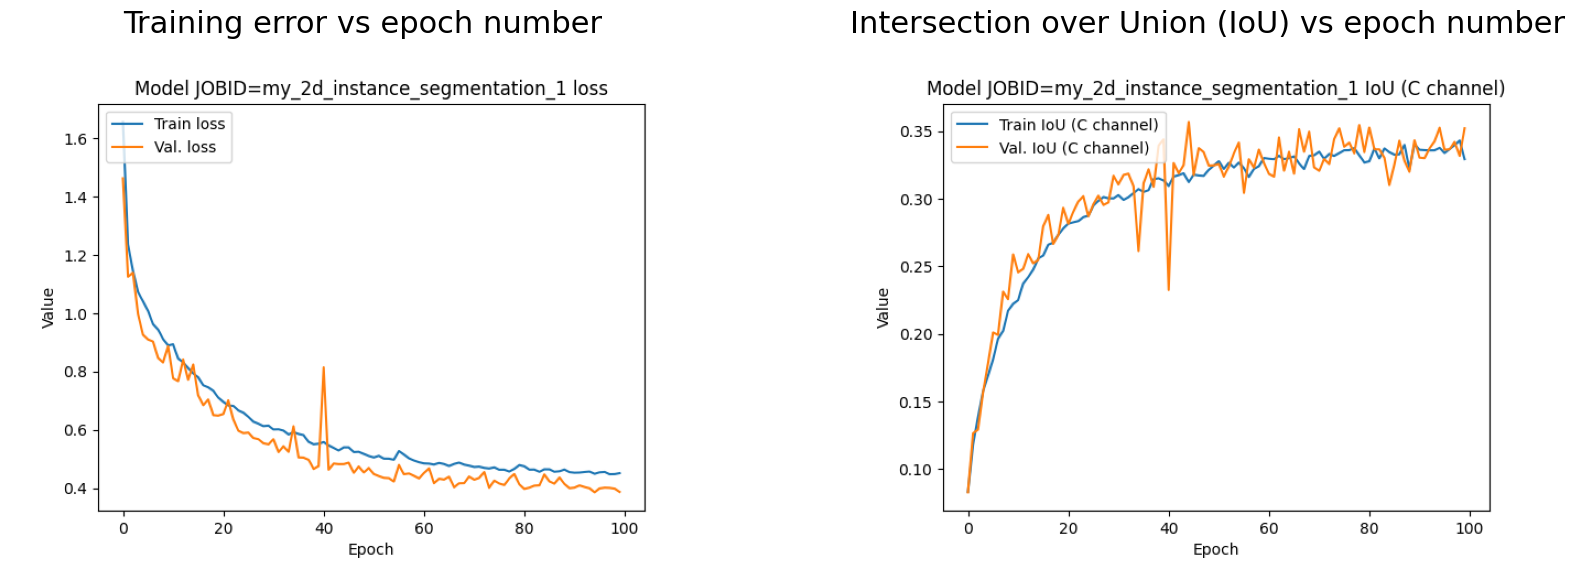

In [13]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and IoU vs epoch number
#@markdown #### Each channel that composes the instance representation has its own chart. Here, only the first plot found in the 'chart' result folder is shown, but there may be more depending on the selected representation.
import matplotlib.pyplot as plt

plot_dir = output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'
plots = sorted(next(os.walk(plot_dir))[2])

loss_file = [x for x in plots if "loss" in x][0]
loss_plot = imread( os.path.join(plot_dir, loss_file))

first_channel_file = [x for x in plots if "loss" not in x][0]
iou_plot = imread( os.path.join(plot_dir, first_channel_file))

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Intersection over Union (IoU) vs epoch number', fontdict = {'fontsize':22})

## **Visualize instance segmentation results (from the test set)**
---

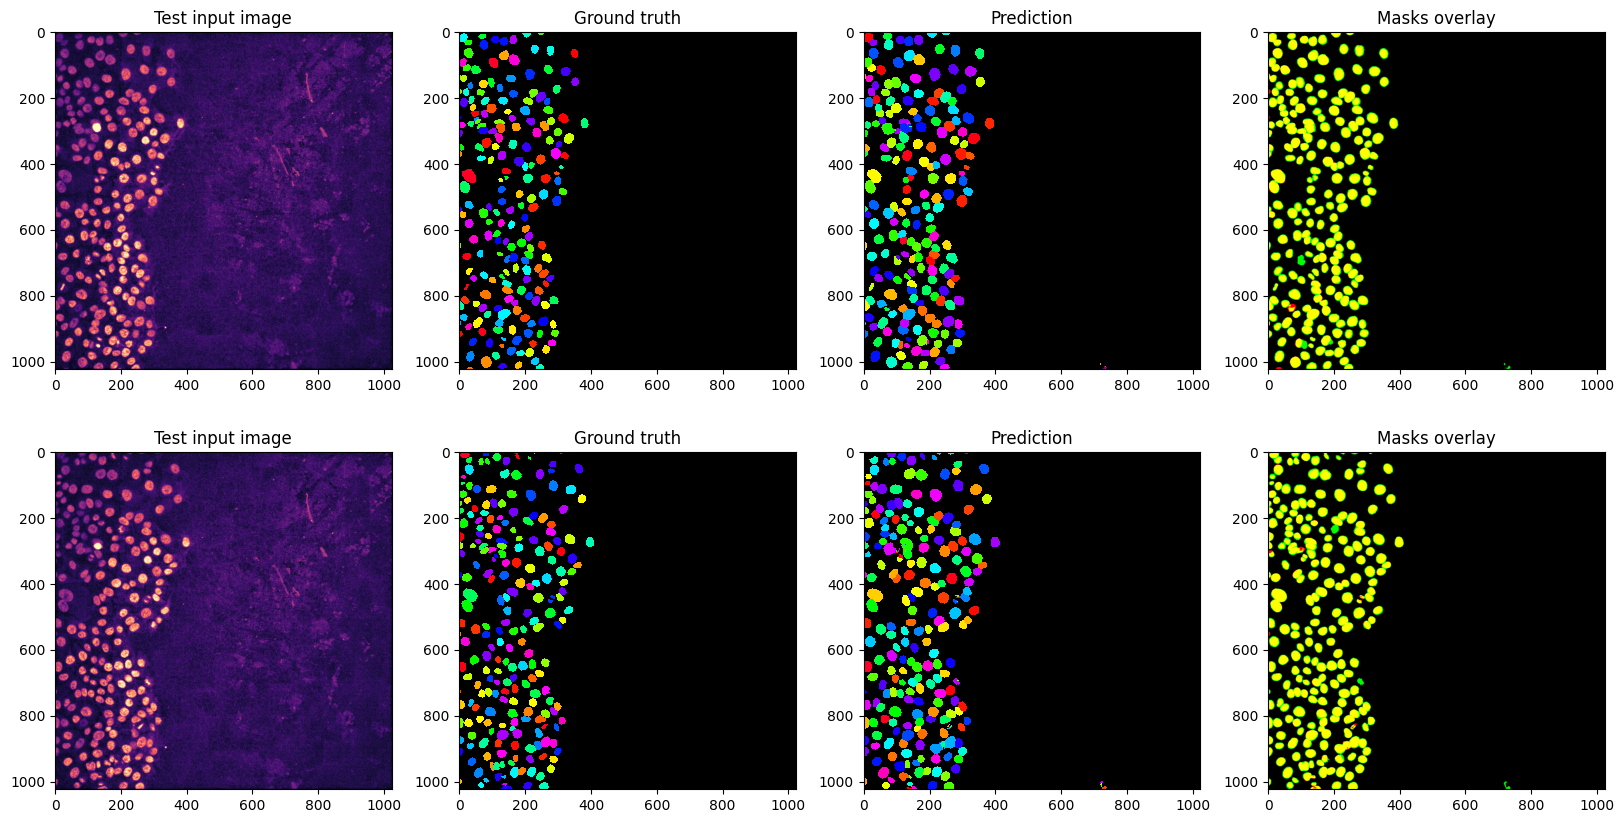

In [14]:
final_results = os.path.join(output_path, job_name, 'results', job_name + "_1")
if biapy_config['TEST']['FULL_IMG']:
    instance_results = os.path.join(final_results, "full_image_instances")
else:
    instance_results = os.path.join(final_results, "per_image_instances")

#@markdown ##Play to visualize some results from the test set
#@markdown The current model will be applied to some test images and results will be shown displaying:
#@markdown 1. The original **Test input image**.
#@markdown 2. Its corresponding **Ground truth** labels.
#@markdown 3. The model **Prediction** labels.
#@markdown 4. The **Masks overlay** (true positive pixels in yellow, false negative pixels in red, and false positive pixels in green).

from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly
%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids_pred = sorted(next(os.walk(instance_results))[2])
ids_input = sorted(next(os.walk(test_data_path))[2])
ids_gt = sorted(next(os.walk(test_data_gt_path))[2])

# create random color map
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_rainbow(vals))
cmap.colors[0] = [0., 0., 0., 1.] # set background to black

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
test_sample_gt = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(instance_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(aux)

    aux = imread(os.path.join(test_data_gt_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(aux)

# Show predicted images
plt.figure(figsize=(20,10))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 4, index)
    plt.title("Test input image")
    plt.imshow(test_samples[j], cmap='magma', vmin=np.percentile(test_samples[j],0.1),vmax=np.percentile(test_samples[j],99.9))

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Ground truth")
    plt.imshow(test_sample_gt[j],  cmap=cmap, interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap=cmap, interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Masks overlay")
    b = np.zeros( test_sample_gt[j].shape )
    overlay = np.dstack( (test_sample_gt[j]>0, test_sample_preds[j]>0, b ))
    plt.imshow( overlay )

    index = index + 1
plt.show()


In [15]:
#@markdown ###Play to display the path to the output files (one 2D TIFF label image for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

if biapy_config['TEST']['FULL_IMG']:
    instance_results = os.path.join(final_results, "full_image_instances")
else:
    instance_results = os.path.join(final_results, "per_image_instances")

print("Output paths:")
print("    Instance segmentation files are in {}".format(instance_results))

[11:44:49.515647] Output paths:
[11:44:49.516459]     Instance segmentation files are in /content/output/my_2d_instance_segmentation/results/my_2d_instance_segmentation_1/per_image_instances


## **Download instance segmentation results**
---

In [ ]:
#@markdown ###Play to download a zip file with all instance segmentation results in test.

from google.colab import files

!zip -q -j /content/instance_segmentation_results.zip $instance_results/*.tif

files.download("/content/instance_segmentation_results.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
---
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
from google.colab import files

#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = str( job_name ) + '_1-checkpoint-best.pth'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Export your model to BioImage Model Zoo format**
---
If you want to export the model into the [BioImage Model Zoo](https://bioimage.io/#/) format, fill the metadata and run the following cell. After the cell is run a `trained_model_name.bmz.zip` file will be downloaded.

In [20]:

#@markdown ##Construct model's metadata to export it to the BioImage Model Zoo format. Choose just one option:

#@markdown **Option 1: Reuse previous BioImage Model Zoo model configuration**

#@markdown With this option, if you were using a model from BioImage Model Zoo you can select this option to reuse its configuration instead of provide all fields manually. If that's not the case and you try to use this option an error will be thrown.
reuse_previous_BMZ_model_config = False #@param {type:"boolean"}

#@markdown ---

#@markdown **Option 2: Manual export fields**

#@markdown With this option you need to introduce manually the metadata of the model.

#@markdown **Note**: use semicolons to separate different text elements.

# ------------- User input ------------
#@markdown Information about the model:
trained_model_name    = "" #@param {type:"string"}
trained_model_authors =  "First Author Name; Second Author Name; Third Author Name" #@param {type:"string"}
trained_model_authors_github_user =  "First Author GitHub Username; Second Author GitHub Username; Third Author GitHub Username" #@param {type:"string"}
trained_model_description = "" #@param {type:"string"}
trained_model_license = 'CC-BY-4.0'#@param {type:"string"}
trained_model_references = "Ronneberger et al. arXiv in 2015; Franco-Barranco, Daniel, et al. ISBI in 2023" #@param {type:"string"}
trained_model_references_DOI = "10.1007/978-3-319-24574-4_28; 10.1109/ISBI53787.2023.10230593" #@param {type:"string"}
trained_model_tags = "tag-1; tag-2" #@param {type:"string"}
#trained_model_documentation = "/content/README.md" #@param {type:"string"}
#@markdown Information about the dataset used to train the model:
trained_model_dataset_name = "StarDist V2" #@param {type:"string"}
trained_model_dataset_doi = "10.1038/s41467-021-22518-0" #@param {type:"string"}
trained_model_dataset_image_modality = "Fluorescence microscopy (SiR-DNA)" #@param {type:"string"}

#@markdown The following field is optional (leave it blank to not use it). It represents the id of the dataset in BMZ page (check [here](https://bioimage.io/#/?type=dataset)). For example, for the [StarDist (2D) example training and test dataset](https://bioimage.io/#/?type=dataset&utterances=58842ffe2b5f50c9229d94aclL0BYDegsx7hAZUO%2B4bf6sl06yH%2BzVdw8klUoz4GRlZri7ag60RDPFYIRpoUnP%2FTuXY2oroxVr0NBaZwY4Dd3WV%2B82u3OOS117L%2BhIxEghu4z6N8WwK4blV63xs%3D&id=bountiful-moon-cake) the ID is `bountiful-moon-cake`.
trained_model_dataset_id = "bountiful-moon-cake" #@param {type:"string"}

In [ ]:
#@markdown ###Play to download a zip file with your [BioImage Model Zoo](https://bioimage.io/#/) exported model

#@markdown If everything is correct, you should see some messages containing 🐍 and ✓ symbols.

#@markdown **Note**: after downloading the zip file, remember to open it and check that its ``documentation.md`` file contains the complete information about the model as you wish to share it.

from google.colab import files
import ast

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
bmz_results = os.path.join(final_results, "bmz_model")

if not reuse_previous_BMZ_model_config:

    # create the author spec input
    auth_names = trained_model_authors.split(";")
    auth_names = [t.strip() for t in auth_names]

    auth_githubusers = trained_model_authors_github_user.split(";")
    auth_githubusers = [t.strip() for t in auth_githubusers]

    refs = trained_model_references.split(";")
    refs = [t.strip() for t in refs]

    dois = trained_model_references_DOI.split(";")
    dois = [t.strip() for t in dois]


    assert len(auth_names) == len(auth_githubusers)
    authors = [{"name": auth_name, "github_user": auth_guser} for auth_name, auth_guser in zip(auth_names, auth_githubusers)]

    # create the citation input spec
    assert len(refs) == len(dois)
    citations = [{'text': text, 'doi': doi} for text, doi in zip(refs, dois)]

    tags = trained_model_tags.split(",")
    tags = [t.strip() for t in tags]

    #with open(trained_model_documentation, "w") as f:
    #    f.write("### **Description**\n")
    #    f.write(f"{trained_model_description}\n\n")
    #    f.write("This model was created using the [BiaPy library](https://biapyx.github.io/).\n")

    bmz_cfg = {}
    # Description of the model
    bmz_cfg['description'] = trained_model_description
    # Authors of the model. Need to be a list of dicts, e.g. authors=[{"name": "Daniel", "github_user": "danifranco"}]
    bmz_cfg['authors'] = authors
    # License of the model. E.g. "CC-BY-4.0"
    bmz_cfg['license'] = trained_model_license
    # List of dictionaries of citations associated, e.g. [{"text": "Gizmo et al.", "doi": "doi:10.1002/xyzacab123"}]
    bmz_cfg['tags'] = tags
    # Tags to make models more findable on the website, e.g. tags=["electron-microscopy", "mitochondria"]
    bmz_cfg['cite'] = citations
    # Path to a file with a documentation of the model in markdown, e.g. "my-model/doc.md"
    #bmz_cfg['doc_path'] = trained_model_documentation
    # Name of the model
    bmz_cfg["model_name"] = trained_model_name
    # Dataset information
    bmz_cfg["data"] = {
        "name": trained_model_dataset_name,
        "doi": trained_model_dataset_doi,
        "image_modality": trained_model_dataset_image_modality,
    }
    if trained_model_dataset_id != "":
        bmz_cfg["data"]["dataset_id"] = trained_model_dataset_id
    biapy.export_model_to_bmz(bmz_results, bmz_cfg)
else:
    try:
        biapy.export_model_to_bmz(bmz_results, reuse_original_bmz_config=True)
    except:
        print("Seems that the was a problem reusing BMZ model specs. Please uncheck 'reuse_previous_BMZ_model_config' and do it manually")

download = True
if not reuse_previous_BMZ_model_config:
    bmz_zip_path = f"/{bmz_results}/{trained_model_name}.zip"
else:
    ids = sorted(next(os.walk(bmz_results))[2])
    ids = [x for x in ids if x.endswith(".zip")]
    if len(ids) > 1:
        print(f"There are more than one ZIP files in {bmz_results} folder. Please check which one you want you want to download and do it manually.")
        download = False
    elif len(ids) == 0:
        print(f"BMZ zip file could not be found.")
        download = False
    else: # only one zip
        ids = ids[0]
    bmz_zip_path = f"/{bmz_results}/{ids}"

if download and os.path.exists(bmz_zip_path):
    files.download(bmz_zip_path)


## **Advanced options**
---
Here you will be able to modify some parameters of the post-processing step to improve your segmentation results.

### **Adjust marker-controlled watershed threshold values**
---
Optionally, you can now play with the different thresholds that are applied to the problem respresentation channels in order to run marker-controlled wathershed and try to improve your results.

In [ ]:
#@markdown ### Marker-controlled watershed parameters:
binary_mask_seed_threshold =  0.9#@param {type:"number"}
binary_mask_grow_threshold =  0.4#@param {type:"number"}
contour_threshold =  0.2 #@param {type:"number"}
central_point_threshold =  0.1 #@param {type:"number"}
distance_seed_threshold =  1.1 #@param {type:"number"}


### **Run inference**
---

In [ ]:
#@markdown ### Play to run inference on test with the new parameters

# Transcribe model architecture

biapy_config_inference = biapy_config.copy()

# set the training to false to peform inference
biapy_config_inference['TRAIN']['ENABLE'] = False

biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_TYPE'] = "manual"
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_BINARY_MASK'] = binary_mask_seed_threshold
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_CONTOUR'] = contour_threshold
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_POINTS'] = central_point_threshold
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_FOREGROUND'] = binary_mask_grow_threshold
biapy_config_inference['PROBLEM']['INSTANCE_SEG']['DATA_MW_TH_DISTANCE'] = distance_seed_threshold

# load weights
biapy_config_inference['MODEL']['LOAD_CHECKPOINT'] = True

# reuse predictions
biapy_config_inference['TEST']['REUSE_PREDICTIONS'] = True

# save file
inference_file = "/content/"+str(job_name)+"_inference.yaml"

with open( inference_file, 'w') as outfile:
    yaml.dump(biapy_config_inference, outfile, default_flow_style=False)

print( "Inference configuration finished.")

# Run the code
biapy = BiaPy( inference_file, result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()


[11:53:47.658708] Inference configuration finished.
[11:53:47.659035] Date     : 2025-03-26 11:53:47
[11:53:47.659084] Arguments: Namespace(config='/content/my_2d_instance_segmentation_inference.yaml', result_dir='/content/output', name='my_2d_instance_segmentation', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
[11:53:47.659097] Job      : my_2d_instance_segmentation_1
[11:53:47.659110] BiaPy    : 3.5.12
[11:53:47.659123] Python   : 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
[11:53:47.659140] PyTorch  : 2.4.0+cu118
[11:53:47.667049] The following changes were made in order to adapt the input configuration:
[11:53:47.670075] Not using distributed mode
[11:53:47.673109] Configuration details:
[11:53:47.673141] AUGMENTOR:
  AFFINE_MODE: reflect
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (

  0%|          | 0/2 [00:00<?, ?it/s]

[11:53:48.559358] Processing image: cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image76.tif
[11:53:48.622117] Creating instances with watershed . . .
[11:53:48.688868] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_instance_segmentation/results/my_2d_instance_segmentation_1/per_image_instances



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[11:53:48.710117] Calculating matching stats . . .
[11:53:48.710339] Its respective image seems to be: /content/data/test/label/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image76.tif
[11:53:51.660355] DatasetMatching: {'criterion': 'iou', 'thresh': 0.3, 'fp': 5, 'tp': 206, 'fn': 3, 'precision': 0.976303317535545, 'recall': 0.9856459330143541, 'accuracy': 0.9626168224299065, 'f1': 0.9809523809523809, 'n_true': 209, 'n_pred': 211, 'mean_true_score': 0.8315800570985347, 'mean_matched_score': 0.8436904462795813, 'panoptic_quality': 0.8276201520647322}
[11:53:51.660460] Creating the image with a summary of detected points and false positives with colors . . .
[11:53:51.661043] Painting TPs and FNs . . .



100%|██████████| 209/209 [00:00<00:00, 349.47it/s]

0it [00:00, ?it/s]


[11:53:52.269789] Painting FPs . . .



100%|██████████| 5/5 [00:00<00:00, 318.89it/s]


[11:53:52.290804] Saving (1, 1, 1024, 1024, 3) data as .tif in folder: /content/output/my_2d_instance_segmentation/results/my_2d_instance_segmentation_1/instance_associations



 50%|█████     | 1/2 [00:03<00:03,  3.92s/it]

[11:53:52.400283] DatasetMatching: {'criterion': 'iou', 'thresh': 0.5, 'fp': 7, 'tp': 204, 'fn': 5, 'precision': 0.966824644549763, 'recall': 0.9760765550239234, 'accuracy': 0.9444444444444444, 'f1': 0.9714285714285714, 'n_true': 209, 'n_pred': 211, 'mean_true_score': 0.827768280175314, 'mean_matched_score': 0.848056718414905, 'panoptic_quality': 0.8238265264601935}
[11:53:52.466690] DatasetMatching: {'criterion': 'iou', 'thresh': 0.75, 'fp': 29, 'tp': 182, 'fn': 27, 'precision': 0.8625592417061612, 'recall': 0.8708133971291866, 'accuracy': 0.7647058823529411, 'f1': 0.8666666666666667, 'n_true': 209, 'n_pred': 211, 'mean_true_score': 0.756406647166567, 'mean_matched_score': 0.8686208200978709, 'panoptic_quality': 0.7528047107514881}
[11:53:52.478406] Processing image: cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image86.tif
[11:53:52.537127] Creating instances with watershed . . .
[11:53:52.613043] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_ins


  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[11:53:52.632560] Calculating matching stats . . .
[11:53:52.632826] Its respective image seems to be: /content/data/test/label/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image86.tif
[11:53:56.700491] DatasetMatching: {'criterion': 'iou', 'thresh': 0.3, 'fp': 12, 'tp': 224, 'fn': 2, 'precision': 0.9491525423728814, 'recall': 0.9911504424778761, 'accuracy': 0.9411764705882353, 'f1': 0.9696969696969697, 'n_true': 226, 'n_pred': 236, 'mean_true_score': 0.836921759411297, 'mean_matched_score': 0.8443942751203265, 'panoptic_quality': 0.8188065698136499}
[11:53:56.700618] Creating the image with a summary of detected points and false positives with colors . . .
[11:53:56.701154] Painting TPs and FNs . . .



100%|██████████| 226/226 [00:00<00:00, 353.22it/s]

0it [00:00, ?it/s]


[11:53:57.350092] Painting FPs . . .



100%|██████████| 12/12 [00:00<00:00, 359.88it/s]


[11:53:57.388610] Saving (1, 1, 1024, 1024, 3) data as .tif in folder: /content/output/my_2d_instance_segmentation/results/my_2d_instance_segmentation_1/instance_associations



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[11:53:57.503334] DatasetMatching: {'criterion': 'iou', 'thresh': 0.5, 'fp': 16, 'tp': 220, 'fn': 6, 'precision': 0.9322033898305084, 'recall': 0.9734513274336283, 'accuracy': 0.9090909090909091, 'f1': 0.9523809523809523, 'n_true': 226, 'n_pred': 236, 'mean_true_score': 0.8295147651064713, 'mean_matched_score': 0.8521378950639205, 'panoptic_quality': 0.8115599000608766}


100%|██████████| 2/2 [00:09<00:00,  4.52s/it]

[11:53:57.587862] DatasetMatching: {'criterion': 'iou', 'thresh': 0.75, 'fp': 46, 'tp': 190, 'fn': 36, 'precision': 0.8050847457627118, 'recall': 0.8407079646017699, 'accuracy': 0.6985294117647058, 'f1': 0.8225108225108225, 'n_true': 226, 'n_pred': 236, 'mean_true_score': 0.7404159950999032, 'mean_matched_score': 0.8807053415398849, 'panoptic_quality': 0.7243896748596456}
[11:53:57.590362] Releasing memory . . .
[11:53:57.590569] #############
[11:53:57.590618] #  RESULTS  #
[11:53:57.590639] #############
[11:53:57.590656] The values below represent the averages across all test samples
[11:53:57.591805] Test IoU (B channel) (merge patches): 0.7887057065963745
[11:53:57.591849] Test IoU (C channel) (merge patches): 0.12347393855452538
[11:53:57.591875]  
[11:53:57.591897] Instance segmentation specific metrics:
[11:53:57.591935] IoU TH=0.3
[11:53:57.591956]       Merge patches:
[11:53:57.591998]       DatasetMatching(criterion='iou', thresh=0.3, fp=17, tp=430, fn=5, precision=0.9619686

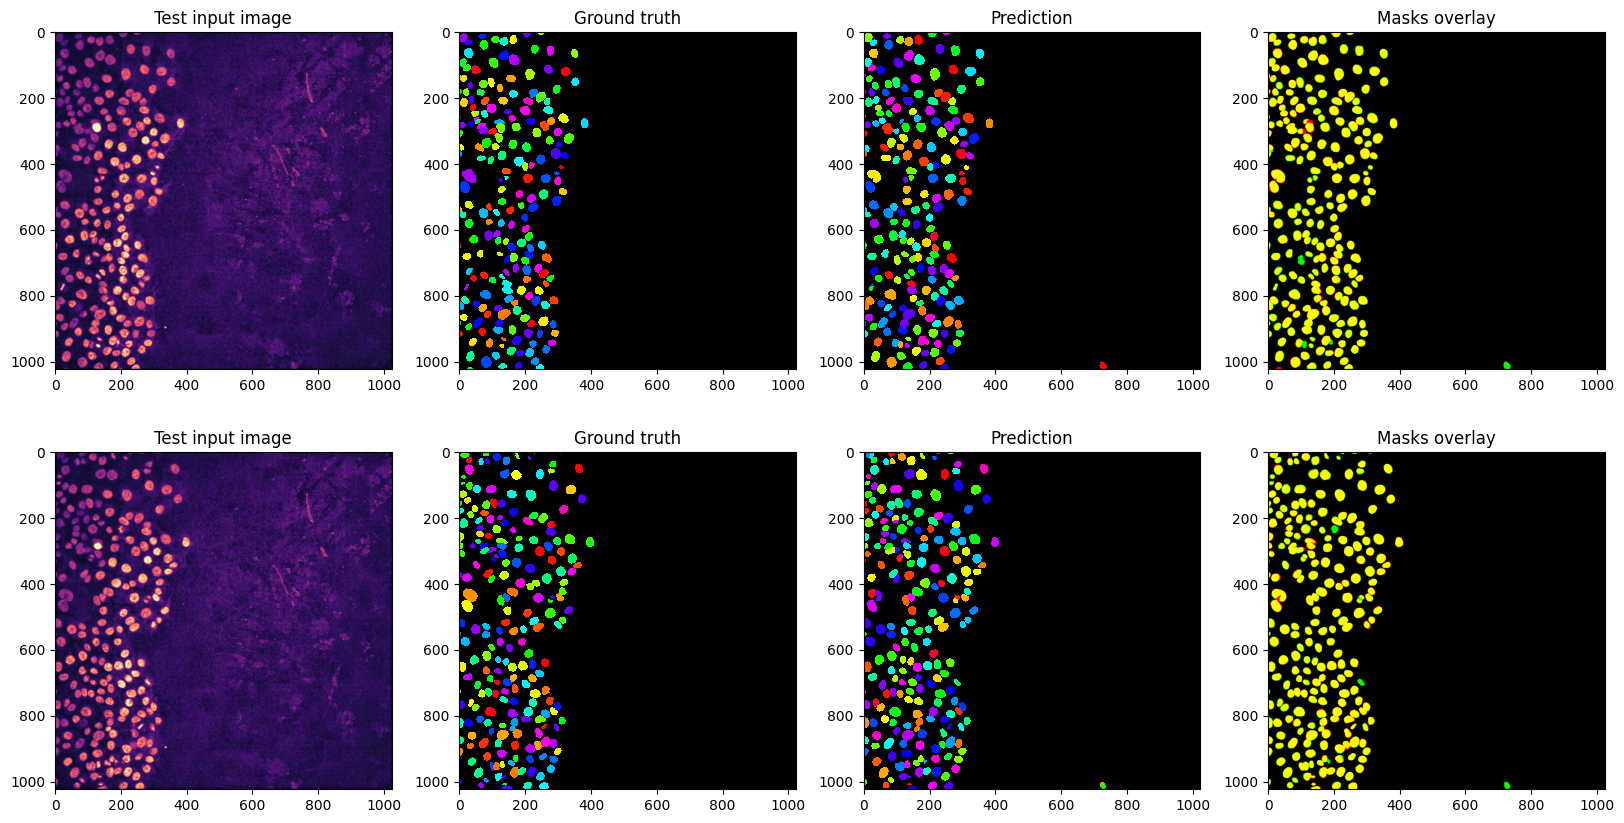

In [ ]:
#@markdown ##Play to visualize some results from the test set
#@markdown The current model will be applied to some test images and results will be shown displaying:
#@markdown 1. The original **Test input image**.
#@markdown 2. Its corresponding **Ground truth** labels.
#@markdown 3. The model **Prediction** labels.
#@markdown 4. The **Masks overlay** (true positive pixels in yellow, false negative pixels in red, and false positive pixels in green).

test_samples = []
test_sample_preds = []
test_sample_gt = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(instance_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(aux)

    aux = imread(os.path.join(test_data_gt_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(aux)

# Show predicted images
plt.figure(figsize=(20,10))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 4, index)
    plt.title("Test input image")
    plt.imshow(test_samples[j], cmap='magma', vmin=np.percentile(test_samples[j],0.1),vmax=np.percentile(test_samples[j],99.9))

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Ground truth")
    plt.imshow(test_sample_gt[j],  cmap=cmap, interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap=cmap, interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Masks overlay")
    b = np.zeros( test_sample_gt[j].shape )
    overlay = np.dstack( (test_sample_gt[j]>0, test_sample_preds[j]>0, b ))
    plt.imshow( overlay )

    index = index + 1
plt.show()


## **How to use the trained model with new data**
---
To directly infer new data to the trained model, you can use [this notebook](https://github.com/BiaPyX/BiaPy/blob/master/notebooks/BiaPy_Inference.ipynb). It will be necessary to upload the downloaded YAML configuration file and model weights to that notebook.

## **Acknowledgments**
---
We extend our gratitude to the [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki) for their invaluable inspiration. Notably, we have adopted some of their descriptions concerning metrics and parameters.
